# Euclid catalogs flux/magnitudes checks.

This notebook describe how to use the photometry package to recompute galaxies and star magnitudes and compare to the official SimTrueUniverse products

## Package installation

### Downloading
Download the photometry package:
```
git clone https://github.com/haussel/photometry.git
```
and make sure the `photometry/` directory is in your `PYTHONPATH`. Also check the `README` file and make sure you have all dependencies installed. 

### Setup
All Euclid and EXT passbands are provided with the `photometry` package, in the `photometry/data/passbands/Euclid/` directory, and the relevant classes will know how to find the passband files. 

For the spectra, SimTrueUniverse uses three libraries stored as FITS files. `photometry` expect to find these files in the following directories:
* `/path/to/galaxy/libraries/OU-SIM/EUC-TEST-GSEDLIB-2015-03-18T171100.000.fits`
* `/path/to/galaxy/libraries/OU-SIM/EUC-TEST-GEXTLAWLIB-2015-03-18T203100.000.fits`
* `/path/to/stellar/libraries/OU-SIM/EUC-TEST-SEDLIB-2013-11-14T152700.000.fits`

Edit the `config.py` file and modify accordingly the two lines:
```
STELLAR_LIBRARY_DIR = '/path/to/galaxy/libraries/'
GALAXY_LIBRARY_DIR = '/path/to/stellar/libraries/'
```
Note that given `/path/to/stellar/libraries/` and `/path/to/galaxy/libraries/`, `photometry` expect the SimTrueUniverse libraries to be in the subdirectory `OU-SIM/`.

### TU input/output files
This notebook will present comparison with both SimTrueUniverse results and Euclid flagship catalogs provided by CosmoHub. These files are not distributed, but you probably have some in hand.

That's all, you are good to go !


In [1]:
# imports we will need
%matplotlib inline
import numpy as np
import photometry as ph
from astropy.table import Table
from matplotlib import pyplot as plt
from astropy import units as u
from astropy.io import fits
import os
from matplotlib.colors import LogNorm
from matplotlib import gridspec

## Comparing photometry and True Universe results

### Setting up

#### Locations of the SimTrueUniverse catalog
Edit the following cell with your files locations

In [2]:
# location of the SimTrueUniverse catalog and spectra
tudir = '/Users/haussel/work/euclid/spv2/stuff/flagship/TU/'
# name of the galaxy catalog
tugalcat = 'myTUGalaxyCatalog.fits'
tugalspe = 'myTUGalaxySpectra.fits'
tustarcat = 'myTUStarCatalog.fits'
tustarspe = 'myTUStarSpectra.fits'

#### Galaxy spectra library.

Spectra will be constructed from the information in the catalogs, using the galaxy spectra library. Giving the tendency in Euclid of ctalog column names to change from one version to the other, one need to provide a text file indicating which column is what in the catalog. Here's what the file should look like for our TU catalogs

```
> cat setup_tu.txt
Halpha: logf_halpha_ext
Hbeta: logf_hbeta_ext
OII: logf_o2_ext
OIII: logf_o3_ext
NII: logf_n2_ext
SII: logf_s2_ext
SED: sed_template
EXT: ext_law
EBV: ebv
Z: z_obs
R01_ABS_MAG: abs_mag_r01
REFERENCE_MAG: ref_mag_r01
MW_AV: Av
```

So we generate the spectra library object with the following command:

In [3]:
galspe = ph.EuclidOUSIMGalaxies(setup=os.path.join(tudir, 'setup_tu.txt'))

#### Passbands

For this exercise where SimTrueUniverse only computed Euclid band (and not EXT) photometry, we will use the following passbands:

In [4]:
pbs = [{'file': 'VIS.Euclid.pb', 'outCol': 'TU_Fnu_VIS', 'band': None},
       {'file': 'y_NISP.Euclid.pb', 'outCol': 'TU_Fnu_NIR_Y', 'band': None},
       {'file': 'J_NISP.Euclid.pb', 'outCol': 'TU_Fnu_NIR_J', 'band': None},
       {'file': 'H_NISP.Euclid.pb', 'outCol': 'TU_Fnu_NIR_H', 'band': None}]

We now instatiate the passbands objects:

In [5]:
for i, pb in enumerate(pbs):
    pbs[i]['band'] = ph.Passband(file=pbs[i]['file'])

In [6]:
# we can check for example the H passband:
print(pbs[3]['band'])

################# Header ######################
# file: H_NISP.Euclid.pb
# instrument: Euclid
# system: AB
# xtype: wavelength
# ytype: qe
# description: Full system QE, based on BOL detector QE and EOL Transmission.
# comment: SPV2 values from SPV02 branch of the Euclid MDB
# comment: Total QE value below 1e-7 have been set to 0.
# comment: QE: SpaceSegment.Instrument.NISP.MeanDetectorQuantumEfficiencyCBENominalBOL
# comment: Transmission: SpaceSegment.PLM.PLMTransmissionNISPCBENominalEOL
# comment: Filter: SpaceSegment.Instrument.NISP.NISPYTransmissionCBENominalEOL
# url: http://euclid.esac.esa.int/epdb/db/SPV02/
# reference: Euclid Consortium Mission Performance Document, V 2.0
# filter: H_NISP
# xref: 1775.0 nm
# xunit: nm
############### End of Header #################
Internal settings:
    location method: both_spectrum_and_passband
    interpolation method: quadratic
    integration method: trapezoidal



We can now load the galaxy catalog:

In [7]:
tugalcat = Table.read(os.path.join(tudir, tugalcat))

In [8]:
tugalcat

id,ra,dec,ra_mag,dec_mag,kappa,gamma1,gamma2,z_true,z_obs,abs_mag_r01,ref_mag_r01,euclid_nisp_h,sed_template,ext_law,ebv,g-r,lsfr,metallicity,lmstellar,logf_halpha_ext,logf_hbeta_ext,logf_o2_ext,logf_o3_ext,logf_n2_ext,logf_s2_ext,bulge_fraction,bulge_length,bulge_axis_ratio,bulge_angle,disk_length,disk_axis_ratio,disk_angle,stamp_file_id,stamp_index,spectra_index,SED_INDEX,Av,VIS,NIR_Y,NIR_J,NIR_H,spectra_hdu
int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes256,int32,int32,int32,float64,float64,float64,float64,float64,int16
-1591430960,223.80731,13.82948,223.81042,13.828755,-0.0032498164,-0.00012770617,0.0032577508,0.30183262,0.30096015,-17.62128,22.586018,21.887207,23.710602,2,0.09963688,0.58924484,-0.42706913,8.547746,9.2073965,-16.608776,-17.116898,-16.436522,-16.70003,-17.461124,-17.067232,0.2120015,0.016190287,0.36218962,67.31237,0.076368734,0.36218962,67.31237,,0,0,0,0.048769146949052815,22.391920673796285,22.043332581182895,21.93589051959808,21.895021440414148,2
1104714544,223.66048,13.831919,223.66714,13.83663,-0.0075891637,0.004287639,0.007333521,0.5879896,0.5887998,-19.811972,23.11691,20.693228,25.233103,3,0.38473752,1.0460387,1.0312325,9.36287,10.148244,-15.866093,-16.521324,-16.669622,-16.66035,-16.305859,-16.845055,0.011082058,0.013728594,0.72341514,140.358,1.2388128,0.72341514,140.358,,0,0,1,0.06425958741456271,22.19504445509347,21.290855226527032,20.94994348929312,20.685187002757054,2
-1980619264,223.44592,13.725409,223.45435,13.731512,-0.0135042025,-0.013006034,0.002243551,0.823773,0.8258427,-20.365778,23.868368,20.959223,22.879253,2,0.3166056,0.8685717,0.95419973,9.000859,10.472501,-15.868671,-16.4904,-15.983115,-16.284302,-16.431356,-16.4646,0.18174514,0.08262846,0.9703195,160.94107,0.45463914,0.9703195,160.94107,,0,0,2,0.06662337742745876,22.88235630152856,21.722330121129364,21.32485565360207,20.95704579798406,2
-810875552,223.24654,13.905483,223.25024,13.904768,-0.0021930356,0.0008794815,-0.0014656249,0.27494055,0.27618486,-17.188335,22.830307,21.891706,21.934467,2,0.07565985,0.6810964,-0.7799641,8.082955,9.074614,-16.868551,-17.371563,-17.216167,-16.639362,-18.53412,-17.991692,0.0005013392,0.00022407195,0.82439715,7.7733727,0.4469468,0.82439715,7.7733727,,0,0,3,0.05750386584550143,22.584543138845298,22.140864661029266,22.00064267951857,21.907310866279698,2
1941675544,223.97885,13.693621,223.98312,13.6944475,-0.0050533284,0.0013340496,-0.0014580227,0.37987185,0.3798334,-19.033842,21.81301,21.065388,23.182795,2,0.03941746,0.7221216,0.004746457,8.949378,9.746268,-16.085497,-16.56965,-15.890589,-17.403976,-16.4253,-16.357475,0.039828625,0.026094563,0.47297847,67.709206,0.65517104,0.47297847,67.709206,,0,0,4,0.05245052855461836,21.539258619373847,21.23087529081748,21.10542966117499,21.069153691879702,2
-473588509,223.46681,13.99288,223.47127,13.991879,-0.0045793755,-0.0007614016,-0.0009841812,0.33866477,0.34039757,-19.878593,21.408981,18.43713,18.832354,2,0.39581066,1.3544532,0.5705427,8.903847,10.526455,-15.994924,-16.657463,-16.337015,-16.172972,-16.926853,-16.868065,0.03250921,0.049059305,0.8447486,70.93101,1.5090892,0.8447486,70.93101,,0,0,5,0.054543531686067584,20.518890910841886,19.333030630770125,18.802415198340427,18.436495085218027,2
978452330,223.88629,13.700692,223.89294,13.707207,-0.0016050298,0.005302824,-0.0033297676,0.8668187,0.86778647,-19.436705,24.138857,22.322704,27.88159,4,0.31529638,0.6016224,1.0152527,8.807985,9.903123,-15.913538,-16.53427,-16.908392,-15.728961,-17.637535,-17.439175,0.076792754,0.026028888,0.93476087,172.2582,0.3389498,0.93476087,172.2582,,0,0,6,0.06627248506993055,23.60201918473471,22.869839028115603,22.550668940976273,22.320978259170193,2
1179682944,223.08698,13.97225,223.09123,13.983292,0.023611726,0.008506177,0.027297808,1.0741497,1.0743344,-21.231894,23.7

In order to perform the test quickly, we will only check a randomly chosen fraction of this catalog, say of 10000 sources over the 85958 in the catalog

In [9]:
nbobj = 10000
checked = np.random.choice(len(tugalcat), size=nbobj, replace=False)

We now proceed to compute the objects magnitudes. In order to save memory, we proceed by chunks of 500 sources at a time. 

In [10]:
nbpbs = len(pbs)
result = np.zeros((nbpbs, nbobj), dtype=float)
chunksize = 500
for ifrom in range(0, nbobj, chunksize):
    ito = ifrom+chunksize
    if ito > nbobj:
        ito = nbobj
    print("Working on chunk {}:{} of {}".format(ifrom, ito, nbobj))
    # build the spectra corresponding the catalog sources. spe is a BasicSpectrum object.
    spe = galspe(tugalcat[checked][ifrom:ito])
    # as all the computations are in the AB system, work in frequencies from the start
    spe.in_nu(reinterpolate=False)
    spe.in_fnu(reinterpolate=True)
    # for all bands, compute the AB mag
    for j, pb in enumerate(pbs):
        result[j, ifrom:ito] = pb['band'].mag_ab(spe)

Working on chunk 0:500 of 10000


/Users/haussel/work/python/photometry/photcurve.py:283: RuntimeWarning: invalid value encountered in less
  idx = np.where(self.y < 0)


Working on chunk 500:1000 of 10000
Working on chunk 1000:1500 of 10000
Working on chunk 1500:2000 of 10000
Working on chunk 2000:2500 of 10000
Working on chunk 2500:3000 of 10000
Working on chunk 3000:3500 of 10000
Working on chunk 3500:4000 of 10000
Working on chunk 4000:4500 of 10000
Working on chunk 4500:5000 of 10000
Working on chunk 5000:5500 of 10000
Working on chunk 5500:6000 of 10000
Working on chunk 6000:6500 of 10000
Working on chunk 6500:7000 of 10000
Working on chunk 7000:7500 of 10000
Working on chunk 7500:8000 of 10000
Working on chunk 8000:8500 of 10000
Working on chunk 8500:9000 of 10000
Working on chunk 9000:9500 of 10000
Working on chunk 9500:10000 of 10000


Text(0.5,0,'SED Cosmos')

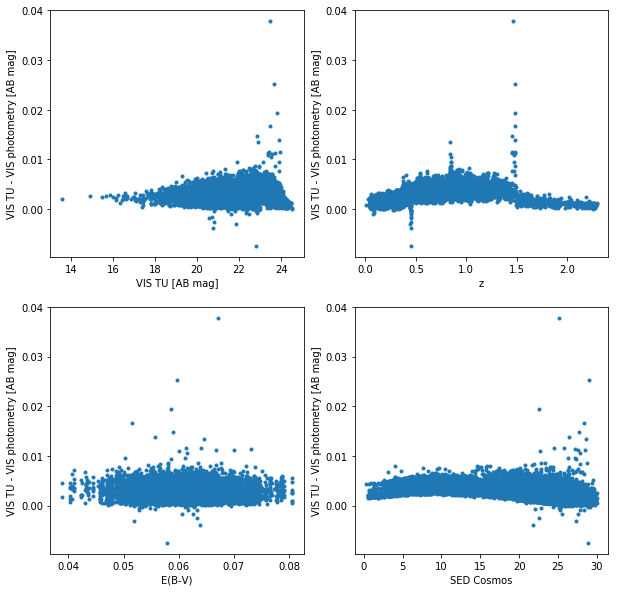

In [11]:
plt.figure(0, (10,10))
gs = gridspec.GridSpec(2, 2)

ax = plt.subplot(gs[0,0])
plt.plot(tugalcat['VIS'][checked], tugalcat['VIS'][checked]-result[0,:], '.')
plt.xlabel('VIS TU [AB mag]')
plt.ylabel('VIS TU - VIS photometry [AB mag]')
ax = plt.subplot(gs[1,0])
plt.plot(tugalcat['Av'][checked], tugalcat['VIS'][checked]-result[0,:] , '.')
plt.ylabel('VIS TU - VIS photometry [AB mag]')
plt.xlabel('E(B-V)')
ax = plt.subplot(gs[0,1])
plt.plot(tugalcat['z_obs'][checked], tugalcat['VIS'][checked]-result[0,:], '.')
plt.ylabel('VIS TU - VIS photometry [AB mag]')
plt.xlabel('z')
ax = plt.subplot(gs[1,1])
plt.plot(tugalcat['sed_template'][checked], tugalcat['VIS'][checked]-result[0,:], '.')
plt.ylabel('VIS TU - VIS photometry [AB mag]')
plt.xlabel('SED Cosmos')



Text(0.5,0,'SED Cosmos')

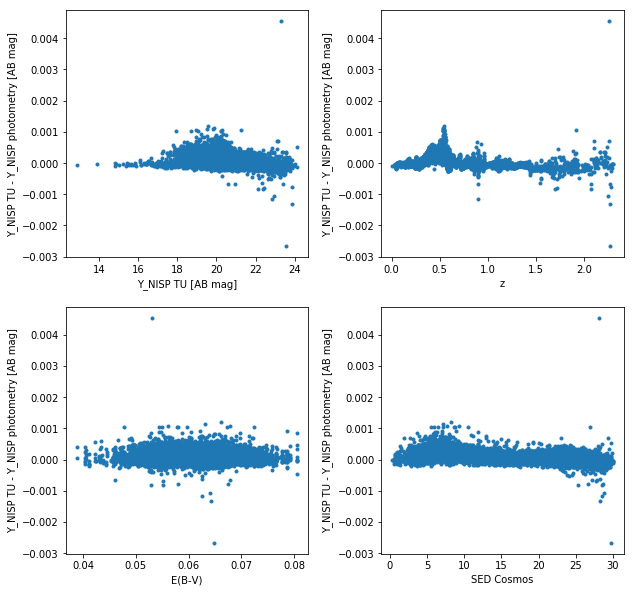

In [12]:
plt.figure(0, (10,10))
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.3)
ax = plt.subplot(gs[0,0])
plt.plot(tugalcat['NIR_Y'][checked], tugalcat['NIR_Y'][checked]-result[1,:], '.')
plt.xlabel('Y_NISP TU [AB mag]')
plt.ylabel('Y_NISP TU - Y_NISP photometry [AB mag]')
ax = plt.subplot(gs[1,0])
plt.plot(tugalcat['Av'][checked], tugalcat['NIR_Y'][checked]-result[1,:] , '.')
plt.ylabel('Y_NISP TU - Y_NISP photometry [AB mag]')
plt.xlabel('E(B-V)')
ax = plt.subplot(gs[0,1])
plt.plot(tugalcat['z_obs'][checked], tugalcat['NIR_Y'][checked]-result[1,:], '.')
plt.ylabel('Y_NISP TU - Y_NISP photometry [AB mag]')
plt.xlabel('z')
ax = plt.subplot(gs[1,1])
plt.plot(tugalcat['sed_template'][checked], tugalcat['NIR_Y'][checked]-result[1,:], '.')
plt.ylabel('Y_NISP TU - Y_NISP photometry [AB mag]')
plt.xlabel('SED Cosmos')




Text(0.5,0,'SED Cosmos')

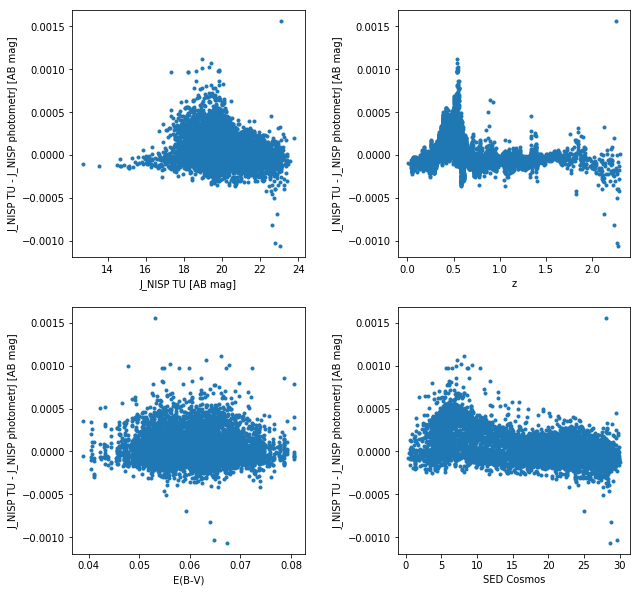

In [13]:
plt.figure(0, (10,10))
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.4)


ax = plt.subplot(gs[0,0])
plt.plot(tugalcat['NIR_J'][checked], tugalcat['NIR_J'][checked]-result[2,:], '.')
plt.xlabel('J_NISP TU [AB mag]')
plt.ylabel('J_NISP TU - J_NISP photometrJ [AB mag]')
ax = plt.subplot(gs[1,0])
plt.plot(tugalcat['Av'][checked], tugalcat['NIR_J'][checked]-result[2,:] , '.')
plt.ylabel('J_NISP TU - J_NISP photometrJ [AB mag]')
plt.xlabel('E(B-V)')
ax = plt.subplot(gs[0,1])
plt.plot(tugalcat['z_obs'][checked], tugalcat['NIR_J'][checked]-result[2,:], '.')
plt.ylabel('J_NISP TU - J_NISP photometrJ [AB mag]')
plt.xlabel('z')
ax = plt.subplot(gs[1,1])
plt.plot(tugalcat['sed_template'][checked], tugalcat['NIR_J'][checked]-result[2,:], '.')
plt.ylabel('J_NISP TU - J_NISP photometrJ [AB mag]')
plt.xlabel('SED Cosmos')



Text(0.5,0,'SED Cosmos')

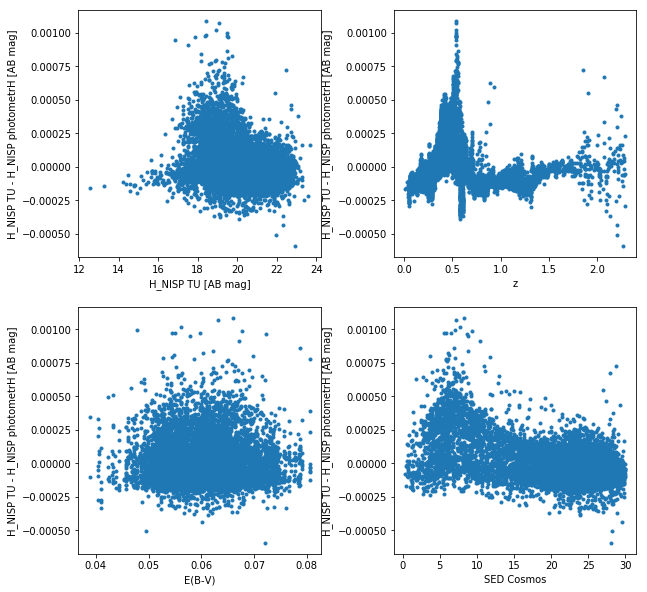

In [14]:
plt.figure(0, (10,10))
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.3)


ax = plt.subplot(gs[0,0])
plt.plot(tugalcat['NIR_H'][checked], tugalcat['NIR_H'][checked]-result[3,:], '.')
plt.xlabel('H_NISP TU [AB mag]')
plt.ylabel('H_NISP TU - H_NISP photometrH [AB mag]')
ax = plt.subplot(gs[1,0])
plt.plot(tugalcat['Av'][checked], tugalcat['NIR_H'][checked]-result[3,:] , '.')
plt.ylabel('H_NISP TU - H_NISP photometrH [AB mag]')
plt.xlabel('E(B-V)')
ax = plt.subplot(gs[0,1])
plt.plot(tugalcat['z_obs'][checked], tugalcat['NIR_H'][checked]-result[3,:], '.')
plt.ylabel('H_NISP TU - H_NISP photometrH [AB mag]')
plt.xlabel('z')
ax = plt.subplot(gs[1,1])
plt.plot(tugalcat['sed_template'][checked], tugalcat['NIR_H'][checked]-result[3,:], '.')
plt.ylabel('H_NISP TU - H_NISP photometrH [AB mag]')
plt.xlabel('SED Cosmos')



The differences between `photometry` and SimTrueUniverse results are small, at a very acceptable level given the differences in interpolation scheme between the two codes. 
We can check where the difference comes from from example in the VIS band where there is a spike at z=1.5. Let's take a look at the 4 worst differences.

In [15]:
iord = np.argsort(np.abs(tugalcat['VIS'][checked]-result[0,:]))

In [16]:
# The culprits are:
largerdiff = Table(tugalcat[checked][iord[-5:]])

In [17]:
# with difference:
largerdiff['VIS']-result[0,iord[-5:]]

0.014764004539170372
0.016660628230575014
0.019412116878829266
0.02523444813347453
0.037782547208760064


In [18]:
# Let's rebuild the spectrum for these peculiars sources:
# Note the extra [] are to force a Table output and not a Row output.
photspe = galspe(largerdiff)

In [19]:
# Let's now examine the spectra computed by TU
hdus = fits.open(os.path.join(tudir,tugalspe))
tuwave = hdus['WAVELENGTH'].data * \
  u.Quantity('1 {}'.format(hdus['WAVELENGTH'].header['UNIT']))
ihdu = tugalcat['spectra_hdu'][checked[iord[-1]]]
ispec = tugalcat['SED_INDEX'][checked[iord[-1]]]
tuspec1 = hdus[ihdu].data[ispec, :] * u.erg/u.s/u.cm**2/u.Angstrom 
ihdu = tugalcat['spectra_hdu'][checked[iord[-2]]]
ispec = tugalcat['SED_INDEX'][checked[iord[-2]]]
tuspec2 = hdus[ihdu].data[ispec, :] * u.erg/u.s/u.cm**2/u.Angstrom 
ihdu = tugalcat['spectra_hdu'][checked[iord[-3]]]
ispec = tugalcat['SED_INDEX'][checked[iord[-3]]]
tuspec3 = hdus[ihdu].data[ispec, :] * u.erg/u.s/u.cm**2/u.Angstrom 
ihdu = tugalcat['spectra_hdu'][checked[iord[-4]]]
ispec = tugalcat['SED_INDEX'][checked[iord[-4]]]
tuspec4 = hdus[ihdu].data[ispec, :] * u.erg/u.s/u.cm**2/u.Angstrom 

/Users/haussel/work/python/photometry/photcurve.py:283: RuntimeWarning: invalid value encountered in less
  idx = np.where(self.y < 0)


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


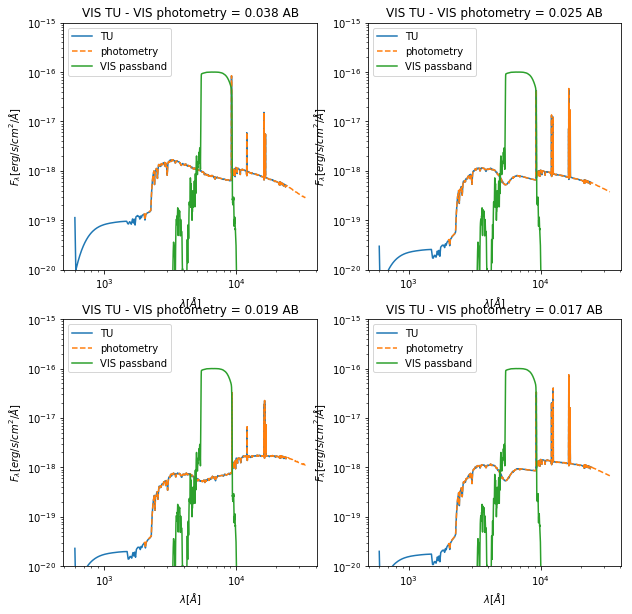

In [20]:
plt.figure(0, (10,10))
gs = gridspec.GridSpec(2, 2)
ax = plt.subplot(gs[0,0])
plt.loglog(tuwave, tuspec1, label='TU')
plt.loglog(photspe[-1].lam(unit=tuwave.unit), photspe[-1].flam(unit=tuspec1.unit), '--', 
           label='photometry')
plt.loglog(pbs[0]['band'].lam(unit=tuwave.unit), 
           pbs[0]['band'].y/np.max(pbs[0]['band'].y)*1e-16, label='VIS passband')
plt.title('VIS TU - VIS photometry = {:.3f} AB'.format(largerdiff['VIS'][-1]-result[0,iord[-1]]))
plt.ylim(1e-20, 1e-15)
plt.xlabel(r'$\lambda [\AA]$')
plt.ylabel(r'$F_{\lambda} [erg/s/cm^{2}/\AA]$')
plt.legend(loc='upper left')

ax = plt.subplot(gs[0,1])
plt.loglog(tuwave, tuspec2, label='TU')
plt.loglog(photspe[-2].lam(unit=tuwave.unit), photspe[-2].flam(unit=tuspec2.unit), '--', 
           label='photometry')
plt.loglog(pbs[0]['band'].lam(unit=tuwave.unit), 
           pbs[0]['band'].y/np.max(pbs[0]['band'].y)*1e-16, label='VIS passband')
plt.title('VIS TU - VIS photometry = {:.3f} AB'.format(largerdiff['VIS'][-2]-result[0,iord[-2]]))
plt.ylim(1e-20, 1e-15)
plt.xlabel(r'$\lambda [\AA]$')
plt.ylabel(r'$F_{\lambda} [erg/s/cm^{2}/\AA]$')
plt.legend(loc='upper left')

ax = plt.subplot(gs[1,0])
plt.loglog(tuwave, tuspec3, label='TU')
plt.loglog(photspe[-3].lam(unit=tuwave.unit), photspe[-3].flam(unit=tuspec3.unit), '--', 
           label='photometry')
plt.loglog(pbs[0]['band'].lam(unit=tuwave.unit), 
           pbs[0]['band'].y/np.max(pbs[0]['band'].y)*1e-16, label='VIS passband')
plt.title('VIS TU - VIS photometry = {:.3f} AB'.format(largerdiff['VIS'][-3]-result[0,iord[-3]]))
plt.ylim(1e-20, 1e-15)
plt.xlabel(r'$\lambda [\AA]$')
plt.ylabel(r'$F_{\lambda} [erg/s/cm^{2}/\AA]$')
plt.legend(loc='upper left')

ax = plt.subplot(gs[1,1])
plt.loglog(tuwave, tuspec4, label='TU')
plt.loglog(photspe[-3].lam(unit=tuwave.unit), photspe[-4].flam(unit=tuspec4.unit), '--', 
           label='photometry')
plt.loglog(pbs[0]['band'].lam(unit=tuwave.unit), 
           pbs[0]['band'].y/np.max(pbs[0]['band'].y)*1e-16, label='VIS passband')
plt.title('VIS TU - VIS photometry = {:.3f} AB'.format(largerdiff['VIS'][-4]-result[0,iord[-4]]))
plt.ylim(1e-20, 1e-15)
plt.xlabel(r'$\lambda [\AA]$')
plt.ylabel(r'$F_{\lambda} [erg/s/cm^{2}/\AA]$')
plt.legend(loc='upper left')






In every cases, the difference seems related to the [OII] line exiting the VIS band. Let's take a closer look.

/Users/haussel/work/python/photometry/photcurve.py:283: RuntimeWarning: invalid value encountered in less
  idx = np.where(self.y < 0)


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


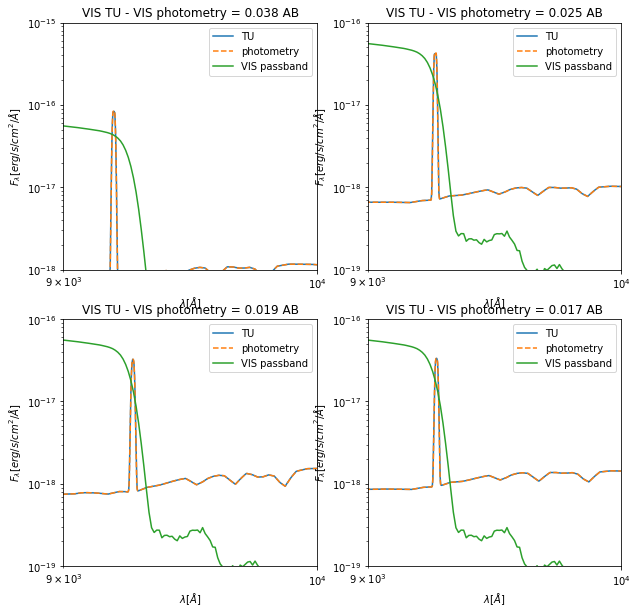

In [21]:
plt.figure(0, (10,10))
gs = gridspec.GridSpec(2, 2)
ax = plt.subplot(gs[0,0])
plt.loglog(tuwave, tuspec1, label='TU')
plt.loglog(photspe[-1].lam(unit=tuwave.unit), photspe[-1].flam(unit=tuspec1.unit), '--', 
           label='photometry')
plt.loglog(pbs[0]['band'].lam(unit=tuwave.unit), 
           pbs[0]['band'].y/np.max(pbs[0]['band'].y)*1e-16, label='VIS passband')
plt.title('VIS TU - VIS photometry = {:.3f} AB'.format(largerdiff['VIS'][-1]-result[0,iord[-1]]))
plt.xlim(9e3,1e4)
plt.ylim(1e-18, 1e-15)
plt.xlabel(r'$\lambda [\AA]$')
plt.ylabel(r'$F_{\lambda} [erg/s/cm^{2}/\AA]$')
plt.legend(loc='upper right')

ax = plt.subplot(gs[0,1])
plt.loglog(tuwave, tuspec2, label='TU')
plt.loglog(photspe[-2].lam(unit=tuwave.unit), photspe[-2].flam(unit=tuspec2.unit), '--', 
           label='photometry')
plt.loglog(pbs[0]['band'].lam(unit=tuwave.unit), 
           pbs[0]['band'].y/np.max(pbs[0]['band'].y)*1e-16, label='VIS passband')
plt.title('VIS TU - VIS photometry = {:.3f} AB'.format(largerdiff['VIS'][-2]-result[0,iord[-2]]))
plt.xlim(9e3,1e4)
plt.ylim(1e-19, 1e-16)
plt.xlabel(r'$\lambda [\AA]$')
plt.ylabel(r'$F_{\lambda} [erg/s/cm^{2}/\AA]$')
plt.legend(loc='upper right')

ax = plt.subplot(gs[1,0])
plt.loglog(tuwave, tuspec3, label='TU')
plt.loglog(photspe[-3].lam(unit=tuwave.unit), photspe[-3].flam(unit=tuspec3.unit), '--', 
           label='photometry')
plt.loglog(pbs[0]['band'].lam(unit=tuwave.unit), 
           pbs[0]['band'].y/np.max(pbs[0]['band'].y)*1e-16, label='VIS passband')
plt.title('VIS TU - VIS photometry = {:.3f} AB'.format(largerdiff['VIS'][-3]-result[0,iord[-3]]))
plt.xlim(9e3,1e4)
plt.ylim(1e-19, 1e-16)
plt.xlabel(r'$\lambda [\AA]$')
plt.ylabel(r'$F_{\lambda} [erg/s/cm^{2}/\AA]$')
plt.legend(loc='upper right')

ax = plt.subplot(gs[1,1])
plt.loglog(tuwave, tuspec4, label='TU')
plt.loglog(photspe[-3].lam(unit=tuwave.unit), photspe[-4].flam(unit=tuspec4.unit), '--', 
           label='photometry')
plt.loglog(pbs[0]['band'].lam(unit=tuwave.unit), 
           pbs[0]['band'].y/np.max(pbs[0]['band'].y)*1e-16, label='VIS passband')
plt.title('VIS TU - VIS photometry = {:.3f} AB'.format(largerdiff['VIS'][-4]-result[0,iord[-4]]))
plt.xlim(9e3,1e4)
plt.ylim(1e-19, 1e-16)
plt.xlabel(r'$\lambda [\AA]$')
plt.ylabel(r'$F_{\lambda} [erg/s/cm^{2}/\AA]$')
plt.legend(loc='upper right')





In all these cases, the spectra simulated by TU and `photometry` are identical. The difference in flux must arise from differences in either the passbands or the way they are interpolated by each program, in a wavelength range where the variation of the transmission is fast. We can check what is the interpolation method used by `photometry`:

In [22]:
print(pbs[0]['band'])

################# Header ######################
# file: VIS.Euclid.pb
# instrument: Euclid
# system: AB
# xtype: wavelength
# ytype: qe
# description: Full system QE, based on BOL detector QE and EOL Transmission.
# comment: SPV2 values from SPV02 branch of the Euclid MDB
# comment: Total QE value below 1e-8 have been set to 0.
# comment: QE: SpaceSegment.Instrument.VIS.MeanDetectorQuantumEfficiencyCBENominalBOL
# comment: Transmission: SpaceSegment.PLM.PLMTransmissionVISCBENominalEOL
# url: http://euclid.esac.esa.int/epdb/db/SPV02/
# reference: Euclid Consortium Mission Performance Document, V 2.0
# filter: VIS
# xref: 718.0 nm
# xunit: nm
############### End of Header #################
Internal settings:
    location method: both_spectrum_and_passband
    interpolation method: quadratic
    integration method: trapezoidal



`photometry` uses a here a quadratic interpolation by default, where SimTrueUniverse uses linear interpolation. It is possible to redo the computations with a linear interpolation by modifying the code of cell 5 :
```
for i, pb in enumerate(pbs):
    pbs[i]['band'] = ph.Passband(file=pbs[i]['file'], interpolation='linear')
```

We will let this to you as an exercise.  

## Comparing photometry and CosmoHub results

### Setting up

#### Locations of the SimTrueUniverse catalog
Edit the following cell with your files locations

In [23]:
# location of the SimTrueUniverse catalog and spectra
chdir = '/Users/haussel/work/euclid/spv2/stuff/flagship/jorge/first/'
# name of the galaxy catalog, downloaded from CosmoHub
chgalcat = '2979.fits'

#### Galaxy spectra library.
For the flagship catalog, here's the setup we use:
```
cat setup_cosmohub.txt
Halpha: logf_halpha_model3_ext
Hbeta: logf_hbeta_model3_ext
OII: logf_o2_model3_ext
OIII: logf_o3_model3_ext
NII: logf_n2_model3_ext
SII: logf_s2_model3_ext
SED: sed_cosmos
EXT: ext_curve_cosmos
EBV: ebv_cosmos
Z: observed_redshift_gal
R01_ABS_MAG: abs_mag_r01_evolved
REFERENCE_MAG: sdss_r01
REFMAG_IS_FLUX: True
MW_EBV: mw_extinction
```
Note that compared to TU, the variable `MW_AV` has been replaced by `MW_EBV`. `photometry` knows the difference and will recompute the $A_{V}$ using a factor $R_{V}=3.1$

Let's generate the library:

In [24]:
galspech = ph.EuclidOUSIMGalaxies(setup=os.path.join(chdir, 'setup_cosmohub.txt'))

#### Passbands

For this exercise cosmohub provides many more passbands:

In [25]:
pbs = [{'file': 'VIS.Euclid.pb', 'outCol': 'TU_Fnu_VIS', 'band': None},
       {'file': 'y_NISP.Euclid.pb', 'outCol': 'TU_Fnu_NIR_Y', 'band': None},
       {'file': 'J_NISP.Euclid.pb', 'outCol': 'TU_Fnu_NIR_J', 'band': None},
       {'file': 'H_NISP.Euclid.pb', 'outCol': 'TU_Fnu_NIR_H', 'band': None},
       {'file': 'g_DECam.Euclid.pb', 'outCol': 'TU_Fnu_DECam_g', 'band': None},
       {'file': 'r_DECam.Euclid.pb', 'outCol': 'TU_Fnu_DECam_r', 'band': None},
       {'file': 'i_DECam.Euclid.pb', 'outCol': 'TU_Fnu_DECam_i', 'band': None},
       {'file': 'z_DECam.Euclid.pb', 'outCol': 'TU_Fnu_DECam_z', 'band': None},
       {'file': 'u_MegaCam.Euclid.pb', 'outCol': 'TU_Fnu_MegaCam_u', 'band': None},
       {'file': 'r_MegaCam.Euclid.pb', 'outCol': 'TU_Fnu_MegaCam_r', 'band': None},
       {'file': 'g_JPCam.Euclid.pb', 'outCol': 'TU_Fnu_JPCam_g', 'band': None},
       {'file': 'i_PS.Euclid.pb', 'outCol': 'TU_Fnu_PS_i', 'band': None},
       {'file': 'z_PS.Euclid.pb', 'outCol': 'TU_Fnu_PS_z', 'band': None},
       {'file': 'z_HSC.Euclid.pb', 'outCol': 'TU_Fnu_HSC_z', 'band': None},
       {'file': 'u_LSST.Euclid.pb', 'outCol': 'TU_Fnu_LSST_u', 'band': None},
       {'file': 'g_LSST.Euclid.pb', 'outCol': 'TU_Fnu_LSST_g', 'band': None},
       {'file': 'r_LSST.Euclid.pb', 'outCol': 'TU_Fnu_LSST_r', 'band': None},
       {'file': 'i_LSST.Euclid.pb', 'outCol': 'TU_Fnu_LSST_i', 'band': None},
       {'file': 'z_LSST.Euclid.pb', 'outCol': 'TU_Fnu_LSST_z', 'band': None},
       {'file': 'y_LSST.Euclid.pb', 'outCol': 'TU_Fnu_LSST_y', 'band': None},
       {'file': 'BP_GAIA.Euclid.pb', 'outCol': 'TU_Fnu_Gaia_BP', 'band': None},
       {'file': 'RP_GAIA.Euclid.pb', 'outCol': 'TU_Fnu_Gaia_RP','band': None},
       {'file': 'G_GAIA.Euclid.pb', 'outCol': 'TU_Fnu_Gaia_G', 'band': None},
       {'file': 'u_KIDS.Euclid.pb', 'outCol': 'TU_Fnu_KIDS_u', 'band': None},
       {'file': 'g_KIDS.Euclid.pb', 'outCol': 'TU_Fnu_KIDS_g', 'band': None},
       {'file': 'r_KIDS.Euclid.pb', 'outCol': 'TU_Fnu_KIDS_r', 'band': None},
       {'file': 'i_KIDS.Euclid.pb', 'outCol': 'TU_Fnu_KIDS_i', 'band': None}, 
       {'file': 'J_2MASS.Euclid.pb', 'outCol': 'TU_Fnu_2MASS_J', 'band': None}, 
       {'file': 'H_2MASS.Euclid.pb', 'outCol': 'TU_Fnu_2MASS_H', 'band': None}, 
       {'file': 'Ks_2MASS.Euclid.pb', 'outCol': 'TU_Fnu_2MASS_Ks', 'band': None}
      ]

In [26]:
for i, pb in enumerate(pbs):
    pbs[i]['band'] = ph.Passband(file=pbs[i]['file'])

In [27]:
incat = Table.read(os.path.join(chdir, chgalcat))

In [28]:
len(incat)

7919554

This is a large file, again we will check a random subsample. Also, the flagship catalog outputs fluxes in erg/s/cm$^{2}/\AA$, so instead of the `Passband.mag_ab()` method we use the `Passband.fnu_ab()` one.

In [29]:
nbobj = 10000
checked = np.random.choice(len(incat), size=nbobj, replace=False)

In [30]:
nbpbs = len(pbs)
result = np.zeros((nbpbs, nbobj), dtype=float)

chunksize = 500

for ifrom in range(0, nbobj, chunksize):
    ito = ifrom+chunksize
    if ito > nbobj:
        ito = nbobj
    print("Working on chunk {}:{} of {}".format(ifrom, ito, nbobj))
    spe = galspech(incat[checked][ifrom:ito])
    spe.in_nu(reinterpolate=False)
    spe.in_fnu(reinterpolate=True)
    for j, pb in enumerate(pbs):
        result[j, ifrom:ito] = pb['band'].fnu_ab(spe).to(u.erg/u.s/u.cm**2/u.Hz)

Working on chunk 0:500 of 10000


/Users/haussel/work/python/photometry/photcurve.py:283: RuntimeWarning: invalid value encountered in less
  idx = np.where(self.y < 0)


Working on chunk 500:1000 of 10000
Working on chunk 1000:1500 of 10000
Working on chunk 1500:2000 of 10000
Working on chunk 2000:2500 of 10000
Working on chunk 2500:3000 of 10000
Working on chunk 3000:3500 of 10000
Working on chunk 3500:4000 of 10000
Working on chunk 4000:4500 of 10000
Working on chunk 4500:5000 of 10000
Working on chunk 5000:5500 of 10000
Working on chunk 5500:6000 of 10000
Working on chunk 6000:6500 of 10000
Working on chunk 6500:7000 of 10000
Working on chunk 7000:7500 of 10000
Working on chunk 7500:8000 of 10000
Working on chunk 8000:8500 of 10000
Working on chunk 8500:9000 of 10000
Working on chunk 9000:9500 of 10000
Working on chunk 9500:10000 of 10000


Let us look at the result in Euclid H band:

Text(0.5,0,'SED Cosmos')

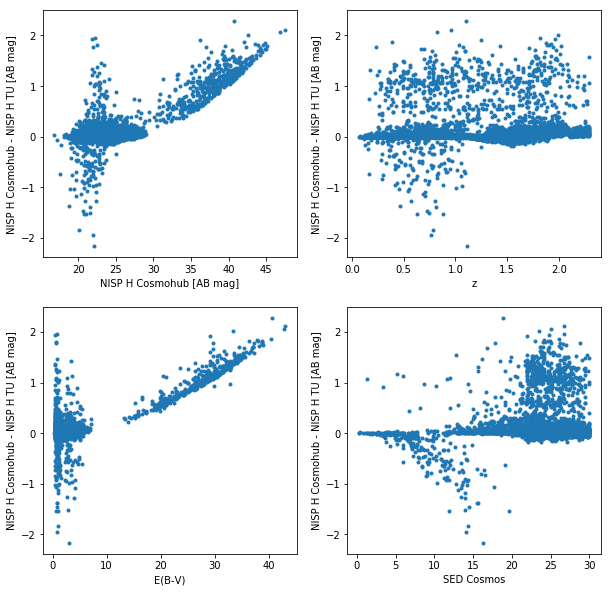

In [31]:
plt.figure(0, (10,10))
gs = gridspec.GridSpec(2, 2)

mag_ch = -2.5 * np.log10(incat['euclid_nisp_h_odonnell_ext'][checked]) - 48.6
mag_ph = -2.5 * np.log10(result[3,:])-48.6

ax = plt.subplot(gs[0,0])
plt.plot(mag_ch, mag_ch-mag_ph, '.')
plt.xlabel('NISP H Cosmohub [AB mag]')
plt.ylabel('NISP H Cosmohub - NISP H TU [AB mag]')
ax = plt.subplot(gs[1,0])
plt.plot(incat['mw_extinction'][checked], mag_ch-mag_ph, '.')
plt.ylabel('NISP H Cosmohub - NISP H TU [AB mag]')
plt.xlabel('E(B-V)')
ax = plt.subplot(gs[0,1])
plt.plot(incat['observed_redshift_gal'][checked], mag_ch-mag_ph, '.')
plt.ylabel('NISP H Cosmohub - NISP H TU [AB mag]')
plt.xlabel('z')
ax = plt.subplot(gs[1,1])
plt.plot(incat['sed_cosmos'][checked], mag_ch-mag_ph, '.')
plt.ylabel('NISP H Cosmohub - NISP H TU [AB mag]')
plt.xlabel('SED Cosmos')



There are big differences, most notably connected to extinction, but also to the SEDs